In [1]:
import razor


In [2]:
import pathlib
HOST_HOME_DIR = str(pathlib.Path.home())

In [3]:
HOST_HOME_DIR

'/home/jovyan'

In [4]:
# razor.api.libraries()

In [5]:
config = {'cpu': 3, 'ram': 25000}

In [6]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [7]:
import razor.flow as rf
from razor.api import datasources
from razor import project_space_path
import razor
from razor import Technology, LibraryMode
# from razor.core.blocks import ContainerExecutor
# from razor.core.blocks.transports import FileTransport


In [8]:
import typing as t

In [9]:
import os
os.path.normpath('/home/jovyan/project-space/M5Forecasting')

'/home/jovyan/project-space/M5Forecasting'

# Light GBM modelling

In [10]:
os.path.exists(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1 .pkl'))

True

In [11]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=18000))
class ConcatenateDF:
    out_df: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
     
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1 .pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        
    def run(self):
        # Read and contact basic feature
        df = pd.concat([pd.read_pickle(self.BASE),
                        pd.read_pickle(self.PRICE).iloc[:,2:],
                        pd.read_pickle(self.CALENDAR).iloc[:,2:]],
                        axis=1)
        self.out_df.put(df.iloc[:5, :5])
        

In [12]:
conc_df = ConcatenateDF()

In [ ]:
conc_df.execute()

In [14]:
lib1 = razor.api.libraries(name='lightgbm').artifact()

In [15]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=18000))
class Train:
#     config: t.Any
    concatenated_df: t.Any
    train_CA_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_CA_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_CA_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_CA_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_CA_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_CA_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_CA_4: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_CA_4: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_TX_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_TX_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_TX_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_TX_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_TX_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_TX_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_WI_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_WI_1: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_WI_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_WI_2: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    train_WI_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    valid_WI_3: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
        
    __libs__ = [lib1]
    
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.LAGS     = project_space_path('M5Forecasting/m5-lags-features/lags_df_28.pkl')
        self.MEAN_ENC = project_space_path('M5Forecasting/m5-custom-features/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = '../input/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]

            
    def seed_everything(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)


    ## Multiprocess Runs
    def df_parallelize_run(self, func, t_split):
        num_cores = np.min([self.N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df

    def get_data_by_store(self, df, store):

        # Leave only relevant store
        df = df[df['store_id']==store]

        # With memory limits we have to read 
        # lags and mean encoding features
        # separately and drop items that we don't need.
        # As our Features Grids are aligned 
        # we can use index to keep only necessary rows
        # Alignment is good for us as concat uses less memory than merge.
        df2 = pd.read_pickle(self.MEAN_ENC)[mean_features]
        df2 = df2[df2.index.isin(df.index)]

        df = pd.concat([df, df2], axis=1)
        del df2 # to not reach memory limit 
        gc.collect()

        df3 = pd.read_pickle(self.LAGS).iloc[:,3:]
        df3 = df3[df3.index.isin(df.index)]


        df = pd.concat([df, df3], axis=1)
        del df3 # to not reach memory limit 
        gc.collect()

        # Create features list
        features = [col for col in list(df) if col not in remove_features]
        df = df[['id','d',self.TARGET]+features]

        # Skipping first n rows
        df = df[df['d']>=self.START_TRAIN].reset_index(drop=True)

        return df, features

    # Recombine Test set after training
    def get_base_test(self):
        base_test = pd.DataFrame()

        for store_id in self.STORES_IDS:
            temp_df = pd.read_pickle('test_'+store_id+'.pkl')
            temp_df['store_id'] = store_id
            base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

        return base_test


    ########################### Helper to make dynamic rolling lags
    #################################################################################
    def make_lag(self, LAG_DAY):
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'sales_lag_{str(LAG_DAY)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
        return lag_df[[col_name]]


    def make_lag_roll(self, LAG_DAY):
        shift_day = LAG_DAY[0]
        roll_wind = LAG_DAY[1]
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
        return lag_df[[col_name]]
    
    
    def split_data(self, df, store_id):
        logging.info('Train')
        logging.info(store_id)

        # Get grid for current store
        grid_df, features_columns = self.get_data_by_store(df, store_id)

        logging.info("Loaded grid Data")

        # Masks for 
        # Train (All data less than 1913)
        # "Validation" (Last 28 days - not real validatio set)
        # Test (All data greater than 1913 day, 
        #       with some gap for recursive features)
        train_mask = grid_df['d']<=self.END_TRAIN
        valid_mask = train_mask&(grid_df['d']>(self.END_TRAIN-self.P_HORIZON))
        preds_mask = grid_df['d']>(self.END_TRAIN-100)

        train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                           label=grid_df[train_mask][self.TARGET])

#             train_data.save_binary(project_space_path("M5Forecasting/train_data.bin"))
#             train_data = lgb.Dataset(project_space_path("M5Forecasting/train_data.bin"))

        valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                           label=grid_df[valid_mask][self.TARGET])

        # Saving part of the dataset for later predictions
        # Removing features that we need to calculate recursively 
        grid_df = grid_df[preds_mask].reset_index(drop=True)
        keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
        grid_df = grid_df[keep_cols]
        grid_df.to_pickle(project_space_path(f"M5Forecasting/test_{store_id}.pkl"))
        del grid_df
        gc.collect()
        
        return train_data, valid_data
            
    
    def run(self):
                         
        import logging


        import lightgbm as lgb
        lgb_params = {
                            'boosting_type': 'gbdt',
                            'objective': 'tweedie',
                            'tweedie_variance_power': 1.1,
                            'metric': 'rmse',
                            'subsample': 0.5,
                            'subsample_freq': 1,
                            'learning_rate': 0.03,
                            'num_leaves': 2**11-1,
                            'min_data_in_leaf': 2**12-1,
                            'feature_fraction': 0.5,
                            'max_bin': 100,
                            'n_estimators': 1400,
                            'boost_from_average': False,
                            'verbose': -1,
                        } 


                ########################### Vars
        #################################################################################
        VER = 1                          # Our model version
        SEED = 42                      
        self.seed_everything(SEED)      
        lgb_params['seed'] = SEED        

        #FEATURES to remove
        ## These features lead to overfit
        ## or values not present in test set
        remove_features = ['id','state_id','store_id',
                           'date','wm_yr_wk','d', self.TARGET]
        mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                           'enc_dept_id_mean','enc_dept_id_std',
                           'enc_item_id_mean','enc_item_id_std'] 


        ROLS_SPLIT = []
        
        for i in [1,7,14]:
            for j in [7,14,30,60]:
                ROLS_SPLIT.append([i,j])


        if self.USE_AUX:
            lgb_params['n_estimators'] = 2

        

        df = self.concatenated_df
        train_data_CA_1, valid_data_CA_1 = self.split_data(df, 'CA_1')
        train_data_CA_2, valid_data_CA_2 = self.split_data(df, 'CA_2')
        train_data_CA_3, valid_data_CA_3 = self.split_data(df, 'CA_3')
        train_data_CA_4, valid_data_CA_4 = self.split_data(df, 'CA_4')
        train_data_TX_1, valid_data_TX_1 = self.split_data(df, 'TX_1')
        train_data_TX_2, valid_data_TX_2 = self.split_data(df, 'TX_2')
        train_data_TX_3, valid_data_TX_3 = self.split_data(df, 'TX_3')
        train_data_WI_1, valid_data_WI_1 = self.split_data(df, 'WI_1')
        train_data_WI_2, valid_data_WI_2 = self.split_data(df, 'WI_2')
        train_data_WI_3, valid_data_WI_3 = self.split_data(df, 'WI_3')
        
        self.train_CA_1.put(train_data_CA_1)
        self.valid_CA_1.put(valid_data_CA_1)
        
        self.train_CA_2.put(train_data_CA_2)
        self.valid_CA_2.put(valid_data_CA_2)
        
        self.train_CA_3.put(train_data_CA_3)
        self.valid_CA_3.put(valid_data_CA_3)
        
        self.train_CA_4.put(train_data_CA_4)
        self.valid_CA_4.put(valid_data_CA_4)

        self.train_TX_1.put(train_data_TX_1)
        self.valid_TX_1.put(valid_data_TX_1)
        
        self.train_TX_2.put(train_data_TX_2)
        self.valid_TX_2.put(valid_data_TX_2)       
        
        self.train_TX_3.put(train_data_TX_3)
        self.valid_TX_3.put(valid_data_TX_3) 

        self.train_WI_1.put(train_data_WI_1)
        self.valid_WI_1.put(valid_data_WI_1) 

        self.train_WI_2.put(train_data_WI_2)
        self.valid_WI_2.put(valid_data_WI_2) 
        
        self.train_WI_3.put(train_data_WI_3)
        self.valid_WI_3.put(valid_data_WI_3)         
        

In [20]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=18000))
class LGBMtrainer:
#     config: t.Any
    train_data: t.Any
    valid_data: t.Any
    
    __libs__ = [lib1]
    
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1 .pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.LAGS     = project_space_path('M5Forecasting/m5-lags-features/lags_df_28.pkl')
        self.MEAN_ENC = project_space_path('M5Forecasting/m5-custom-features/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = '../input/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]
    
    
    def run(self):
        import lightgbm as lgb

        lgb_params = {
                            'boosting_type': 'gbdt',
                            'objective': 'tweedie',
                            'tweedie_variance_power': 1.1,
                            'metric': 'rmse',
                            'subsample': 0.5,
                            'subsample_freq': 1,
                            'learning_rate': 0.03,
                            'num_leaves': 2**11-1,
                            'min_data_in_leaf': 2**12-1,
                            'feature_fraction': 0.5,
                            'max_bin': 100,
                            'n_estimators': 1400,
                            'boost_from_average': False,
                            'verbose': -1,
                        } 


                ########################### Vars
        #################################################################################
        VER = 1                          # Our model version
        SEED = 42                      
        self.seed_everything(SEED)      
        lgb_params['seed'] = SEED 


        self.seed_everything(SEED)
        estimator = lgb.train(lgb_params,
                              self.train_data,
                              valid_sets = [self.valid_data],
                              verbose_eval = 100,
                              )


        model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
        pickle.dump(estimator, open(project_space_path(f"M5Forecasting/{model_name}", 'wb')))
    
    
    

In [16]:
train = Train(concatenated_df=conc_df.out_df)


In [22]:
CA_1 = LGBMtrainer(train_data=train.train_CA_1, valid_data=train.valid_CA_1)
CA_2 = LGBMtrainer(train_data=train.train_CA_2, valid_data=train.valid_CA_2)
CA_3 = LGBMtrainer(train_data=train.train_CA_3, valid_data=train.valid_CA_3)
CA_4 = LGBMtrainer(train_data=train.train_CA_4, valid_data=train.valid_CA_4)
TX_1 = LGBMtrainer(train_data=train.train_TX_1, valid_data=train.valid_TX_1)
TX_2 = LGBMtrainer(train_data=train.train_TX_2, valid_data=train.valid_TX_2)
TX_3 = LGBMtrainer(train_data=train.train_TX_3, valid_data=train.valid_TX_3)
WI_1 = LGBMtrainer(train_data=train.train_WI_1, valid_data=train.valid_WI_1)
WI_2 = LGBMtrainer(train_data=train.train_WI_2, valid_data=train.valid_WI_2)
WI_3 = LGBMtrainer(train_data=train.train_WI_3, valid_data=train.valid_WI_3)



In [14]:
# p = rf.Pipeline("Train", targets=[CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3])  #preprocess
p = rf.Pipeline("Train", targets=[conc_df])

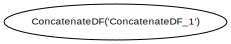

In [15]:
p

In [16]:
# lib1 = razor.api.libraries(name='lightgbm').artifact()


In [17]:
# deployed_pipeline = razor.api.engines('DS-Engine-Load-Test').execute(pipeline=p)
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [19]:
deployed_pipeline


PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='36c23788-fe39-11ea-968a-0242ac110005', pipeline_name='Train', pipeline_run_id='9379b1c4-8a3e-4fc8-bc3f-32e7bf1c9efa', pipeline_version=None, comment=None, created_on='2020-09-24T07:40:29.214+00:00', start_time=None, end_time=None, eta=0, run_at=1600933229214, run_duration=0, compute_time=0, wait_time=549, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='9379b1c4-8a3e-4fc8-bc3f-32e7bf1c9efa', pipeline_name='Train', pipeline_status='IN_PROGRESS', block_id='c0c6743b-c463-4a49-8a82-6b8762da15f6', block_run_id='55b00575-a865-4090-8aac-0199dd76784a', block_name='ConcatenateDF_1', resource_spec=ResourceAllocated(cores=2, memory=18000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='c0c6743b-c463-4a49-8a82-6b8762da15f6', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-09-24T07:40:29.000+00:00')], run_number=147, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='c0c6743b-c463-4a49-8a82-6b8762da15f6', block_run_id='55b00575-a865-4090-8aac-0199dd76784a', block_name='ConcatenateDF_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-09-24T07:40:29.331+00:00', queued_at='2020-09-24T07:40:29.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='6d3fa4ed-ef5d-4015-a7d0-98634a73e68b', output_name='out_df', created_on='2020-09-24T07:40:29.367+00:00', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=2, memory=18000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "36c23788-fe39-11ea-968a-0242ac110005",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Train",\n  "description": "",\n  "blocks": [\n    {\n      "name": "ConcatenateDF_1",\n      "id": "c0c6743b-c463-4a49-8a82-6b8762da15f6",\n      "artifact_id": null,\n      "class_name": "ConcatenateDF",\n      "code": "eJyVVl1z20QUlWQ7cVLS0hTa4WOA4ckFYidNmtRMBya4LRQTtZOUBx5gZy2tsoplSUirlDBhBqbTNpTlqcsTw0CBF34CL/yC/ic4u5Jrh+kDOGNndfdqd++955y7X9d/+GveMh95zouSwk9Dbxix9tRYyRdIxviBn1HBSD5kERNJTLyI5rl6qFrcks+RER0+bU42B0UYiTDOlayLg5TBKBd6SexhrRjfK9cUd1q83uKzvMkbciYZ7DFPwO2u+krJWUL8xCNEubl8zWfexirzuyuXaHeNeeuXBht+98KFlbW15WB50F1VrlDbeKsl5wkZJX4RMbwpm3igYayHpwihcZwIKsIkzmHBFjNJIYgfKDlHkpQhxiTDvrtMhIKN9HEXM/plkrWDKLndhm9aCAQzc8OM9PwM4grjXSVrm/EBDPdwiJyf5S+f/8YcphHRAYuUK2dyloUsV9/KOmdRCkuZEv6qrMd0hMFZOScyGudpkgkln5/a+IkZey9cCyN264nfQ1VtNBfmZLwFb7myIRJUENucyFnss4wYd1cuZMxj4f7EMP95wQqUL/ySqb4lT3GakzAORUgjmHz1bTGQ8/qoxOPMG6ojPNe1g0LtT5IgjCISFLGns1oh4tQEEWYKZlgXSAUHMsZCs5f47JZ+uIu0tfp238LX6fd6y8Ly7Tu275yzDi1i46l2x8bIwahuRjWMGmZU960dSyHkha2L1xKER3NhSmJ3lHzzmK0zuriUh6M0YksB6+xmoU9Smgmy8lo7HUZKvvGfvC/8H+dV4yxQocU0SzS8SZ5Sj2FWcKTgxvb196+7mx+BIu9t7lxVsnFz+3rvqk7O5kdX3Sub23hZ1nMWBciSfPVymB4InsRLYQwILq2sLHWD9fXllZVuwNbpO4qv9xu9puWctOfxp86f17T48G98NEpOEOzrDemuJoer2aGxhzE/U9yv+DO7GyUDGuV44O/L10sc0jRse4i27VNBSZ4UGUIY0RgrgTFv3YyoCJJsdAWzO2Zyq5xrPyXohyqXTZ8FtIiAaBDBD0F6sPEkhCcvMkb2aVQwPTVTMhnH4y2+LmvQA1jPkSmFInkxKL1y9amSJ6Y4rtdsfl7QyBBMLh6TnrbBsJwf3p4cpRDbspYVseKXWvxt/m4JSac/C0hmwtoDEH9xDq292qPxqP7I3mv4lm/ddXxb/wbOC1Y1N/O0ud2a7/i1752vAN292V+ah6VPHT7mV/s8sm2rAjU2t2WdfhHmqH6/oXHkpD50xzOxIN6MUUCtFGt+nX8IckbIEu9DUGpapUDULelA5O4pfoMP+8/05jU8XrZfsZvHAMJ3KgjwT1D6FJSdQ26B6VJo5ExKY5/mhqw5/8zlBG7U5QNTnSH3XO5/qn

In [20]:
razor.api.engines('DS-engine').health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.104.139', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=8, available=8, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=8589934592.0, available=32212254720.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=27, available=5, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=58099499008.0, available=65380810752.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')])])

In [21]:
razor.api.engines('DS-engine').queue()

Block,Pipeline,Wait Time(hours:minutes:seconds)
Filter_1,Pipeline_9,0:10:38
ConcatenateDF_1,Train,0:02:17


In [25]:
os.path.exists('/root/project-space/M5Forecasting/m5-simple-fe/grid_part_1.pkl')

False

In [43]:
project_space_path('')

'/home/jovyan/project-space'

In [34]:
deployed_pipeline.show()

In [103]:
razor.api.engines('DS-engine').health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.115.94', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=10, available=6, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=10737418240.0, available=30064771072.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=7, available=25, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=30635196416.0, available=92845113344.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.95', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=12, used=0, available=12, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=55834574848.0, used=0.0, available=55834574848.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=1, used=0, available=1, value='GPU')])])

In [ ]:
# Recombine Test set after training
def get_base_test():
    import time
    
    
    def df_parallelize_run(func, t_split):
        num_cores = np.min([N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df
    
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

    return base_test
    
    
    VER = 1                          # Our model version
    SEED = 42                        # We want all things
    self.seed_everything(SEED)            # to be as deterministic 
    lgb_params['seed'] = SEED        # as possible
    N_CORES = psutil.cpu_count()     # Available CPU cores


    #LIMITS and const
    TARGET      = 'sales'            # Our target
    START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
    END_TRAIN   = 1913               # End day of our train set
    P_HORIZON   = 28                 # Prediction horizon
    USE_AUX     = True               # Use or not pretrained models




In [121]:
pwd

'/home/jovyan/work/models'